### Transfer Learning
### Assignment # 5
### Muhammad Sufian (MSDS17037)

## Task 1 - VGG16 (FC Layer Changes)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### Load Dataset from Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Copy of Assignment 5 Dataset.zip" #-d "/content/drive/My Drive"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
data_dir =  'Assignment 5 Dataset'# '/content/drive/My Drive/Assignment 5 Dataset'

In [7]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(256),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.3, 0.3, 0.3])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=6, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=6, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


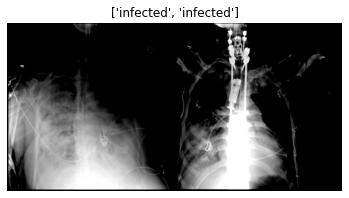

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(testloader))
show_databatch(inputs[0:2], classes[0:2])

### Load pre-trained VGG-16

In [9]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Removing FC Layers

In [10]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())
print(features)
# There are three FC layers in VGG-16, removing last layer to make them 2 
features = features[:-3]# remove ReLU, Dropput and Output Linear layer
#Remove last linear layer
features = features[:-1]
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=1000, bias=True)]
[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

### Adding New FC Layers

In [0]:
#Replace the first FC layer, so keeping the ReLU and doprout as is in next layers
features[0] = nn.Linear(vgg16.classifier[0].in_features, (37*10)+100)
#Add new layer for output
features.extend([nn.Linear((37*10)+100, len(class_names))])

In [13]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss fucntion and optimizer

In [0]:
Epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

### Training

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.267345: : 188it [06:47,  2.17s/it]
0it [00:00, ?it/s]



Epoch: 1
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     526     89
                    57     828


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.163621: : 188it [06:32,  2.09s/it]




Epoch: 2
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     534     81
                    49     836
Finished Training


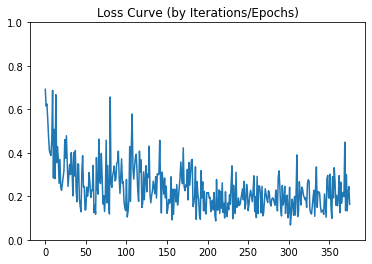

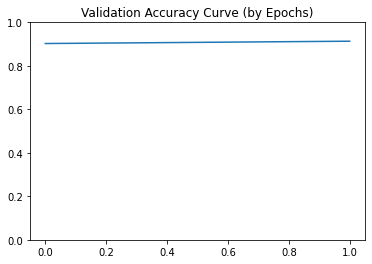

In [15]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

k=0

validation_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    pred_label = np.zeros(0)
    true_label = np.zeros(0)    
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item())#loss.data[0])
                )
     
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

    #validation 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu())
            true_label = np.append(true_label,labels.cpu())
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nEpoch:",k)
    plt.title("Confusion Matrix on Validation set")
    conf = confusion_matrix(true_label, pred_label)
    print("                   Actual Class")
    print("Predicted Class    TP      FP")
    print("                   FN      TN")
    print("")
    print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
    print("                   ",conf[1,0],"   ",conf[1,1])    

print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


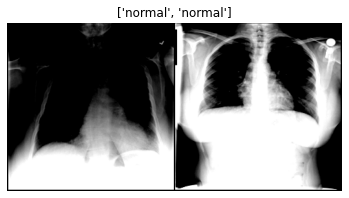

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images[0:2], labels[0:2])

In [17]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected normal normal infected
Ground Truth:  normal normal infected normal normal infected


In [18]:
from sklearn.metrics import f1_score

correct = 0
total = 0
pred_label = np.zeros(0)
true_label = np.zeros(0)    

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu())
        true_label = np.append(true_label,labels.cpu())


print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the test images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print("Confusion Matrix for test images")
print("-------------------------")
conf = confusion_matrix(true_label, pred_label)
print("                   Actual Class")
print("Predicted Class    TP      FP")
print("                   FN      TN")
print("")
print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
print("                   ",conf[1,0],"   ",conf[1,1])

Accuracy
-------------------------
Accuracy of the network on the test images: 96 %


F1 Measure
-------------------------
F1 measure on the test images: 0.9692333205766043


Confusion Matrix for test images
-------------------------
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     580     35
                    11     874


## Task 1 - ResNet18 (FC Layer Changes)

In [19]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

### Remove FC Layer

In [20]:
num_features = resnet18.fc.out_features
in_features = resnet18.fc.in_features
features = list(resnet18.fc.modules())
features = features[:-1]
print(features)

[]


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in resnet18.modules():
    param.require_grad = False

### Adding New FC Layers

In [0]:
#Add the two FC Layers
features.extend([nn.Linear(in_features, (37*10)+100)])
features.extend([nn.Linear((37*10)+100, 2)])

In [23]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss fucntion and optimizer

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.005, momentum=0.9)

### Training

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.277523: : 188it [04:45,  1.52s/it]
0it [00:00, ?it/s]



Epoch: 1
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     519     96
                    129     756


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.325721: : 188it [04:34,  1.46s/it]
0it [00:00, ?it/s]



Epoch: 2
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     534     81
                    189     696


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.227279: : 188it [04:32,  1.45s/it]
0it [00:00, ?it/s]



Epoch: 3
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     561     54
                    152     733


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.061394: : 188it [04:32,  1.45s/it]
0it [00:00, ?it/s]



Epoch: 4
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     521     94
                    134     751


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.144909: : 188it [04:34,  1.46s/it]




Epoch: 5
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     539     76
                    136     749
Finished Training


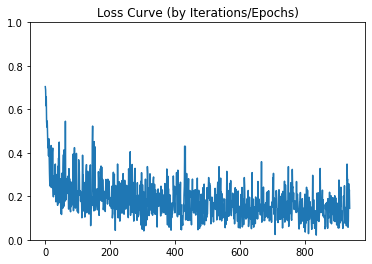

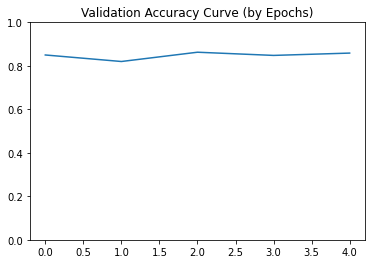

In [25]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

k=0
validation_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    pred_label = np.zeros(0)
    true_label = np.zeros(0)
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item())#loss.data[0])
                )
     
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')

    #validation 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu())
            true_label = np.append(true_label,labels.cpu())            
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nEpoch:",k)
    plt.title("Confusion Matrix on Validation set")
    conf = confusion_matrix(true_label, pred_label)
    print("                   Actual Class")
    print("Predicted Class    TP      FP")
    print("                   FN      TN")
    print("")
    print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
    print("                   ",conf[1,0],"   ",conf[1,1])    

print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


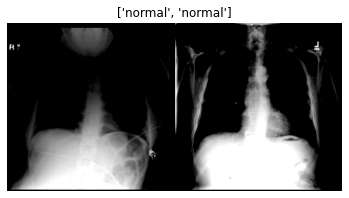

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images[0:2], labels[0:2])

In [27]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal infected normal
Ground Truth:  normal normal normal normal infected normal


In [28]:
from sklearn.metrics import f1_score

correct = 0
total = 0
pred_label = np.zeros(0)
true_label = np.zeros(0)   

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu())
        true_label = np.append(true_label,labels.cpu())        

print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the test images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print("Confusion Matrix for test images")
print("-------------------------")
conf = confusion_matrix(true_label, pred_label)
print("                   Actual Class")
print("Predicted Class    TP      FP")
print("                   FN      TN")
print("")
print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
print("                   ",conf[1,0],"   ",conf[1,1])

Accuracy
-------------------------
Accuracy of the network on the test images: 91 %


F1 Measure
-------------------------
F1 measure on the test images: 0.911040735514997


Confusion Matrix for test images
-------------------------
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     568     47
                    87     798


## Task 2 - VGG16 (Entire Network Learning)

### Load pre-trained VGG-16

In [30]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Removing FC Layers

In [31]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())
print(features)
# There are three FC layers in VGG-16, removing last layer to make them 2 
features = features[:-3]# remove ReLU, Dropput and Output Linear layer
#Remove last linear layer
features = features[:-1]
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=1000, bias=True)]
[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


### Freezing the layers

In [0]:
# Freeze training for all layers
i=0
for param in vgg16.features.parameters():
    param.requires_grad = True


### Adding New FC Layers

In [0]:
#Replace the first FC layer, so keeping the ReLU and doprout as is in next layers
features[0] = nn.Linear(vgg16.classifier[0].in_features, (37*10)+100)
#Add new layer for output
features.extend([nn.Linear((37*10)+100, len(class_names))])

In [33]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss fucntion and optimizer

In [0]:
Epochs = 4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

### Training

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.267173: : 188it [06:18,  2.02s/it]
0it [00:00, ?it/s]



Epoch: 1
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     551     64
                    79     806


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.147633: : 188it [06:24,  2.05s/it]
0it [00:00, ?it/s]



Epoch: 2
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     584     31
                    127     758


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.281461: : 188it [06:26,  2.06s/it]
0it [00:00, ?it/s]



Epoch: 3
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     528     87
                    35     850


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.097743: : 188it [06:24,  2.05s/it]




Epoch: 4
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     565     50
                    84     801
Finished Training


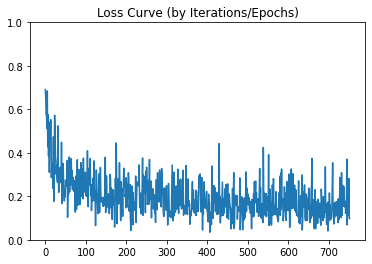

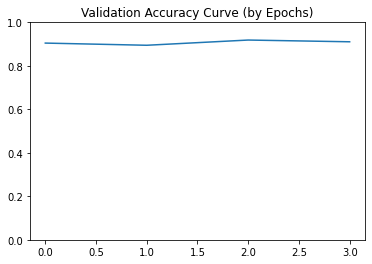

In [35]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

k=0

validation_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    pred_label = np.zeros(0)
    true_label = np.zeros(0)    
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item())#loss.data[0])
                )
     
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')

    #validation 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu())
            true_label = np.append(true_label,labels.cpu())
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nEpoch:",k)
    plt.title("Confusion Matrix on Validation set")
    conf = confusion_matrix(true_label, pred_label)
    print("                   Actual Class")
    print("Predicted Class    TP      FP")
    print("                   FN      TN")
    print("")
    print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
    print("                   ",conf[1,0],"   ",conf[1,1])    

print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


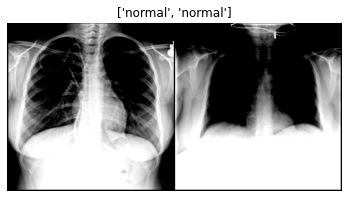

In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images[0:2], labels[0:2])

In [37]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected infected normal normal
Ground Truth:  normal normal infected infected normal normal


In [38]:
from sklearn.metrics import f1_score

correct = 0
total = 0
pred_label = np.zeros(0)
true_label = np.zeros(0)    

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu())
        true_label = np.append(true_label,labels.cpu())


print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the test images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print("Confusion Matrix for test images")
print("-------------------------")
conf = confusion_matrix(true_label, pred_label)
print("                   Actual Class")
print("Predicted Class    TP      FP")
print("                   FN      TN")
print("")
print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
print("                   ",conf[1,0],"   ",conf[1,1])

Accuracy
-------------------------
Accuracy of the network on the test images: 96 %


F1 Measure
-------------------------
F1 measure on the test images: 0.966649869144853


Confusion Matrix for test images
-------------------------
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     588     27
                    23     862


## Task 2 - ResNet18 (Entire Network Learning)

### Load pre-trained ResNet-18

In [39]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Remove FC Layer

In [40]:
num_features = resnet18.fc.out_features
in_features = resnet18.fc.in_features
features = list(resnet18.fc.modules())
features = features[:-1]
print(features) 

[]


### Freezing the layers

In [0]:
for param in resnet18.modules():
    param.requires_grad = True

### Adding New FC Layers

In [0]:
#Add the two FC Layers
features.extend([nn.Linear(in_features, (37*10)+100)])
features.extend([nn.Linear((37*10)+100, 2)])

In [43]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss fucntion and optimizer

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.005, momentum=0.9)

### Training

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.427785: : 188it [04:43,  1.51s/it]
0it [00:00, ?it/s]



Epoch: 1
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     533     82
                    147     738


Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.033517: : 188it [04:41,  1.50s/it]
0it [00:00, ?it/s]



Epoch: 2
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     548     67
                    125     760


Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.273905: : 188it [04:41,  1.50s/it]
0it [00:00, ?it/s]



Epoch: 3
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     537     78
                    135     750


Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.052349: : 188it [04:47,  1.53s/it]
0it [00:00, ?it/s]



Epoch: 4
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     509     106
                    91     794


Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.136127: : 188it [04:44,  1.51s/it]




Epoch: 5
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     556     59
                    155     730
Finished Training


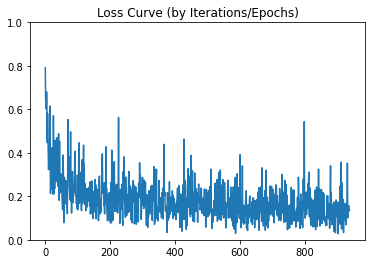

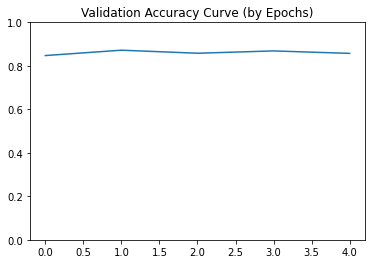

In [45]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

k=0
validation_errors = np.zeros(0)
loss_accumulation = np.zeros(0)

for epoch in range(Epochs):  # loop over the dataset multiple times
    k=k+1
    pred_label = np.zeros(0)
    true_label = np.zeros(0)
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        loss_accumulation = np.append(loss_accumulation,loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item())#loss.data[0])
                )
     
    torch.save(resnet18.state_dict(), 'res18_entire.pth')

    #validation 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_label = np.append(pred_label,predicted.cpu())
            true_label = np.append(true_label,labels.cpu())            
    validation_errors = np.append(validation_errors,correct / total)
    print("\n\nEpoch:",k)
    plt.title("Confusion Matrix on Validation set")
    conf = confusion_matrix(true_label, pred_label)
    print("                   Actual Class")
    print("Predicted Class    TP      FP")
    print("                   FN      TN")
    print("")
    print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
    print("                   ",conf[1,0],"   ",conf[1,1])    

print('Finished Training')
plt.title("Loss Curve (by Iterations/Epochs)")
plt.ylim(0, 1)
plt.plot(loss_accumulation)
plt.show()

plt.title("Validation Accuracy Curve (by Epochs)")
plt.ylim(0, 1)
plt.plot(validation_errors)
plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


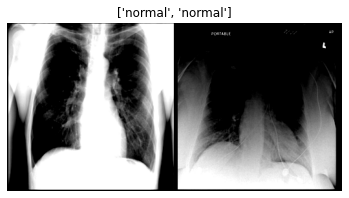

In [46]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images[0:2], labels[0:2])

In [47]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal normal infected
Ground Truth:  normal normal normal normal normal infected


In [48]:
from sklearn.metrics import f1_score

correct = 0
total = 0
pred_label = np.zeros(0)
true_label = np.zeros(0)   

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_label = np.append(pred_label,predicted.cpu())
        true_label = np.append(true_label,labels.cpu())        

print("Accuracy")
print("-------------------------")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print("\n")
print("F1 Measure")
print("-------------------------")
print('F1 measure on the test images:', f1_score(true_label, pred_label, average='weighted'))
print("\n")
print("Confusion Matrix for test images")
print("-------------------------")
conf = confusion_matrix(true_label, pred_label)
print("                   Actual Class")
print("Predicted Class    TP      FP")
print("                   FN      TN")
print("")
print("Predicted Class    ",conf[0,0],"   ",conf[0,1])
print("                   ",conf[1,0],"   ",conf[1,1])

Accuracy
-------------------------
Accuracy of the network on the test images: 90 %


F1 Measure
-------------------------
F1 measure on the test images: 0.9065554010577438


Confusion Matrix for test images
-------------------------
                   Actual Class
Predicted Class    TP      FP
                   FN      TN

Predicted Class     576     39
                    102     783
